In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


#### Before starting with the approach I would really thank Miss.Poonam, She had worked previously for Food reviews dataset by Amazon, in which she had given a beautiful tutorial for SpaCy!

#### I have used her [notebook](https://www.kaggle.com/poonaml/text-classification-using-spacy) as a reference for my approach regarding Covid-19 Text Classification Approach, dealing with Sentiments ranging from "Extreamly Negative"(Score: 0) to "Extreamly Positive"(Score: 5).

* We are going to tackle an interesting natural language processing problem i.e text classification. We will explore texual data using amazing spaCy library and build a text classification model.

In [20]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv')
df.shape 

(41157, 6)

In [22]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [23]:
# Import label encoder
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['Sentiment']= label_encoder.fit_transform(df['Sentiment'])
  
df['Sentiment'].unique()

array([3, 4, 0, 2, 1])

In [24]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,4
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,4
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,4
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


In [25]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

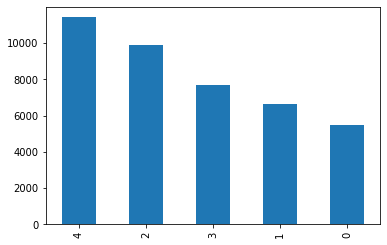

In [26]:
ax = df.Sentiment.value_counts().plot(kind='bar')
fig = ax.get_figure()

Here, Since we are only concered with Sentiment and Tweet we will be extracting those columns seperately in our dataframe, also drop null values(if any!)

In [27]:
df = df[['OriginalTweet','Sentiment']].dropna()
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


In [28]:
df.shape

(41157, 2)

#### Tokenization:
* First step in any nlp pipeline is tokenizing text i.e breaking down paragraphs into sentenses and then sentenses into words, punctuations and so on.

* we will load english language model to tokenize our english text.

* Every language is different and have different rules. Spacy offers 8 different language models.

In [29]:
spacy_tok = spacy.load('en_core_web_sm') #English Language model for tokenization!
sample_review=df.OriginalTweet[32]
sample_review

'Retail store closures could explode because of the #coronavirus (via @CNBC). #BrickAndMortar\r\r\n\r\r\nhttps://t.co/hQrYRNXFhv https://t.co/g5UZn06gb6'

In [30]:
parsed_review = spacy_tok(sample_review)
parsed_review

Retail store closures could explode because of the #coronavirus (via @CNBC). #BrickAndMortar



https://t.co/hQrYRNXFhv https://t.co/g5UZn06gb6

There is not much difference between parsed review and original one. But we will see ahead what has actually happened. We can see how parsing has been done visually through explacy

In [31]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2021-04-29 12:54:14--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py.1’

explacy.py.1        100%[===================>]   6.73K  --.-KB/s    in 0s      

2021-04-29 12:54:14 (56.7 MB/s) - ‘explacy.py.1’ saved [6896/6896]



In [32]:
import explacy
explacy.print_parse_info(spacy_tok, 'Covid-19 has various symtoms') #Text for demonstration

Dep tree Token    Dep type Lemma    Part of Sp
──────── ──────── ──────── ──────── ──────────
   ┌─►   Covid-19 nsubj    Covid-19 PROPN     
┌──┴──   has      ROOT     have     AUX       
│  ┌─►   various  amod     various  ADJ       
└─►└──   symtoms  dobj     symtom   NOUN      


In [33]:
explacy.print_parse_info(spacy_tok, 'India has help various countries with Covid-19 Resources') #Text for demonstration

Dep tree     Token     Dep type Lemma     Part of Sp
──────────── ───────── ──────── ───────── ──────────
        ┌──► India     nsubj    India     PROPN     
        │┌─► has       aux      have      AUX       
┌───────┴┴── help      ROOT     help      VERB      
│        ┌─► various   amod     various   ADJ       
└─►┌─────┴── countries dobj     country   NOUN      
   └─►┌───── with      prep     with      ADP       
      │  ┌─► Covid-19  compound Covid-19  PROPN     
      └─►└── Resources pobj     Resources PROPN     


In [34]:
explacy.print_parse_info(spacy_tok,df.OriginalTweet[2])

Dep tree           Token                   Dep type Lemma                   Part of Sp
────────────────── ─────────────────────── ──────── ─────────────────────── ──────────
               ┌─► Coronavirus             compound Coronavirus             PROPN     
┌┬─────────────┼── Australia               ROOT     Australia               PROPN     
││             └─► :                       punct    :                       PUNCT     
│└─►┌───────────── Woolworths              appos    woolworth               NOUN      
│   │          ┌─► to                      aux      to                      PART      
│   └─►┌┬──────┴── give                    relcl    give                    VERB      
│      ││  ┌─────► elderly                 amod     elderly                 ADJ       
│      ││  │┌────► ,                       punct    ,                       PUNCT     
│      ││  ││┌───► disabled                amod     disabled                ADJ       
│      ││  │││┌──► dedicated               

Part-of-speech tagging
After tokenization we can parse and tag variety of parts of speech to paragraph text. SpaCy uses statistical models in background to predict which tag will go for each word(s) based on the context.

Lemmatization
It is the process of extracting uninflected/base form of the word. Lemma can be like For eg.

Adjectives: best, better → good Adverbs: worse, worst → badly Nouns: ducks, children → duck, child Verbs: standing,stood → stand

In [35]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,Retail,retail,ADJ,JJ,amod,Xxxxx,True,False,False
1,store,"(store,)",NOUN,NN,compound,xxxx,True,False,False
2,closures,"(closure,)",NOUN,NNS,nsubj,xxxx,True,False,False
3,could,"(could,)",VERB,MD,aux,xxxx,True,True,False
4,explode,"(explode,)",VERB,VB,ROOT,xxxx,True,False,False
5,because,"(because,)",SCONJ,IN,prep,xxxx,True,True,False
6,of,"(of,)",ADP,IN,pcomp,xx,True,True,False
7,the,"(the,)",DET,DT,det,xxx,True,True,False
8,#,"(#,)",SYM,$,nmod,#,False,False,True
9,coronavirus,"(coronavirus,)",NOUN,NN,pobj,xxxx,True,False,False


Named Entity Recognition (NER)
Named entity Recognition automatically identifies named entities in a text and classifies them into predefined categories. Entities can be names of people, organizations, locations, times, quantities, monetary values, percentages, and more.


Spacy figures out below entities automatically:

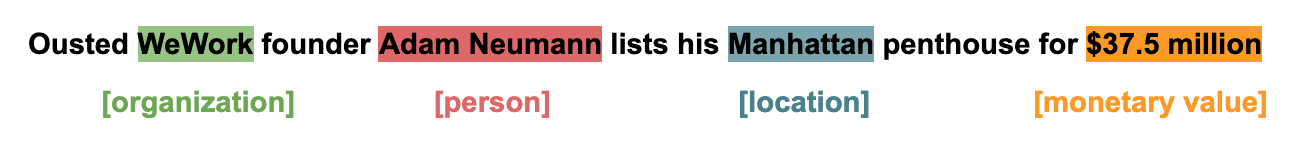

In [36]:
from IPython.display import Image
Image("https://d33wubrfki0l68.cloudfront.net/00d54115351b0e18776433853e794b76b59ee97c/eab3d/static/d0575562cdedb47340c00662c5c1b859/80132/example.png")

In [37]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)

In [38]:
spacy.explain('GPE') # to explain POS tag

'Countries, cities, states'

#### Dependency parsing:
Syntactic Parsing or Dependency Parsing is process of identifyig sentenses and assigning a syntactic structure to it. As in Subject combined with object makes a sentence. Spacy provides parse tree which can be used to generate this structure.

#### Sentense Boundry Detection:
Figuring out where sentense starts and ends is very imporatnt part of nlp.

In [39]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[Retail store closures could explode because of the #coronavirus (via @CNBC).,
 #BrickAndMortar
 
 
 ,
 https://t.co/hQrYRNXFhv https://t.co/g5UZn06gb6]

In [40]:
displacy.render(parsed_review, style='dep', jupyter=True,options={'distance': 140})

In [42]:
options = {'compact': True, 'bg': 'white','distance': 140,
           'color': 'blue', 'font': 'Trebuchet MS'}
displacy.render(parsed_review, jupyter=True, style='dep', options=options)

In [44]:
spacy.explain("ADJ") ,spacy.explain("det") ,spacy.explain("ADP") ,spacy.explain("prep")  
#just to understand what does the tag means!

('adjective', 'determiner', 'adposition', 'prepositional modifier')

In [45]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,Retail store closures,closures,closures,nsubj,explode
1,the #coronavirus,"(coronavirus,)","(coronavirus,)",pobj,because
2,@CNBC,"(@CNBC,)","(@CNBC,)",pobj,via
3,#BrickAndMortar,"(BrickAndMortar,)","(BrickAndMortar,)",ROOT,BrickAndMortar
4,https://t.co/hQrYRNXFhv https://t.co/g5UZn06gb6,"(https://t.co/g5UZn06gb6,)","(https://t.co/g5UZn06gb6,)",ROOT,https://t.co/g5UZn06gb6


In [46]:
!pip install scattertext
import scattertext as st
nlp = spacy.load('en',disable_pipes=["tagger","ner"])

In [49]:
print(df.shape)

(41157, 2)


In [50]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


In [52]:
nlp = spacy.load('en',disable_pipes=["tagger","ner"])
df['parsed'] = df.OriginalTweet.apply(nlp)
corpus = st.CorpusFromParsedDocuments(df,
                             category_col='Sentiment',
                             parsed_col='parsed').build()

In [53]:
df.head()

,OriginalTweet,Sentiment,parsed
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3,"(@MeNyrbie, @Phil_Gahan, @Chrisitv, https://t...."
1,advice Talk to your neighbours family to excha...,4,"(advice, Talk, to, your, neighbours, family, t..."
2,Coronavirus Australia: Woolworths to give elde...,4,"(Coronavirus, Australia, :, Woolworths, to, gi..."
3,My food stock is not the only one which is emp...,4,"(My, food, stock, is, not, the, only, one, whi..."
4,"Me, ready to go at supermarket during the #COV...",0,"(Me, ,, ready, to, go, at, supermarket, during..."


#### Sence2vec
The idea is get something better than word2vec model.

It assight parts of speech tags like verb, noun , adjective to words, which will in turn be used to make sence of context.

Please book [VERB] my ticket.
Read the book [NOUN].

In [54]:
!pip install sense2vec==1.0.0a0

     |████████████████████████████████| 311 kB 887 kB/s eta 0:00:01
     |████████████████████████████████| 179 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 2.3 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-p0l58cc2/sense2vec_d992e4dbaeae4d20b9034ef41b484bae/setup.py'"'"'; __file__='"'"'/tmp/pip-install-p0l58cc2/sense2vec_d992e4dbaeae4d20b9034ef41b484bae/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-cafuvy69
       cwd: /tmp/pip-install-p0l58cc2/sense2vec_d992e4dbaeae4d20b9034ef41b484bae/
  Complete output (127 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.7
  creating build/lib.linux-x86_64-3.7/sense2v

#### SpaCy Text Categorizer
We will train a multi-label convolutional neural network text classifier on our food reviews, using spaCy's new TextCategorizer component.

SpaCy provides classification model with multiple, non-mutually exclusive labels. You can change the model architecture rather easily, but by default, the TextCategorizer class uses a convolutional neural network to assign position-sensitive vectors to each word in the document. The TextCategorizer uses its own CNN model, to avoid sharing weights with the other pipeline components

In [56]:
#Prepare data:
#Let's prepare the data as SpaCy would like it. It accepts list of tuples of text and labels.

In [60]:
df['tuples'] = df.apply(
    lambda row: (row['OriginalTweet'],row['Sentiment']), axis=1)
train = df['tuples'].tolist()
train[:5]

[('@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
  3),
 ('advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
  4),
 ('Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
  4),
 ("My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",
  4),
 ("Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #

In [61]:
#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [62]:
nlp = spacy.load('en_core_web_sm')  # create english Language class

In [64]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading Covid Tweets data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading Covid Tweets data...
Using 30000 examples (24000 training, 6000 evaluation)


In [65]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
4.673	0.894	0.969	0.930
3.601	0.920	0.962	0.940
2.642	0.922	0.965	0.943
1.928	0.920	0.963	0.941
1.362	0.916	0.968	0.941
0.942	0.921	0.962	0.941
0.732	0.924	0.960	0.942
0.573	0.919	0.960	0.939
0.453	0.923	0.957	0.940
0.484	0.923	0.955	0.939


In [66]:
# test the trained model
test_text1 = "Life is worth living than just existing."
test_text2="A strip about Covid that is funny, smart and has good art."
doc = nlp(test_text1)
test_text1, doc.cats

('Life is worth living than just existing.', {'POSITIVE': 0.9828242063522339})

In [67]:
doc2 = nlp(test_text2)
test_text2, doc2.cats

('A strip about Covid that is funny, smart and has good art.',
 {'POSITIVE': 0.9978826642036438})

* As you can see that the sentiments range from 0-100%, where the above text has positivity score of 0.99% which suggests that the tweet is quiet positive!

### Thank you! Hope this Notebook was helpful, Kindly Up-Vote if it helped you in any ways!